In [1]:
import pandas as pd 
import numpy as np
import funciones as fs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


PROCEDEMOS A GENERAR EL DATAFRAME PARA EMPEZAR CON LA LIMPIEZA. 

In [2]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


ANALIZAMOS LA COMPOSICIÓN DE LOS DATOS

In [3]:
fs.dataset_overview(df)

Shape
Rows: 45211 | Columns: 17
Data Types
object    10
int64      7
Name: count, dtype: int64
Missing Values
No missing values


In [4]:
fs.col_numericas(df)


,count,mean,std,min,25%,50%,75%,max,skew
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0,0.684818
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0,8.360308
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0,0.093079
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0,3.144318
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0,4.898650
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0,2.615715
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0,41.846454


DE ACUERDO A LOS COMENTARIOS DEL DATASET, PROCEDEREMOS A ELIMINAR LA COLUMNA "DAY" YA QUE NO NOS SERVIRA PARA DESARROLLAR UN MODELO PREDICTIVO.

In [5]:
columns_drop = ["day"]

In [6]:
fs.drop_columns(df, columns_drop)

LA COLUMNA DURATION HACE REFERENCIA AL TIEMPO DE LLAMADA, SI EL VALOR ES 0 QUIERE DECIR QUE NO FUE CONTESTADA POR LO QUE ANALIZAREMOS SUS VALORES PARA VALORAR SI REALMENTE NOS HACE FALTA PARA NUESTRO MODELO O ES ALGO QUE SE DEFINE POST LLAMADA LO TENDREMOS EN CUENTA.

In [7]:
df["duration"].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

VAMOS A GRAFICARLO PARA VERLO UN POCO MAS CLARO.

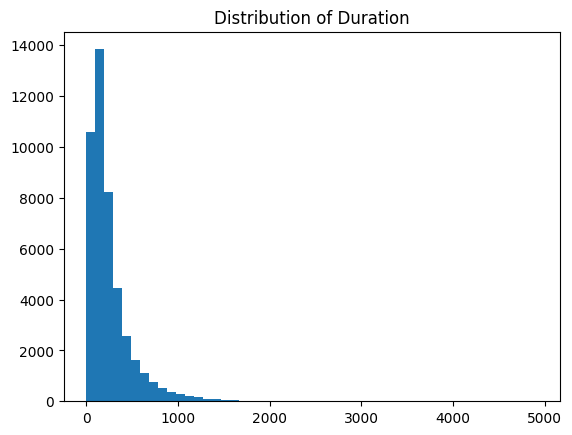

In [8]:
plt.hist(df['duration'], bins=50)
plt.title("Distribution of Duration")
plt.show()

In [9]:
df.groupby('y')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
no,39922.0,221.182806,207.383237,0.0,95.0,164.0,279.0,4918.0
yes,5289.0,537.294574,392.525262,8.0,244.0,426.0,725.0,3881.0


In [10]:
df[df["duration"] < 10]["y"].value_counts(normalize=True)

y
no     0.997076
yes    0.002924
Name: proportion, dtype: float64

In [11]:
df[df["duration"] < 20]["y"].value_counts(normalize=True)

y
no     0.998314
yes    0.001686
Name: proportion, dtype: float64

TENIENDO EN CUENTA QUE LOS VALORES NO SON SIGNIFACTIVOS Y NO INCIDEN EN NUESTRO MODELO(PROBABILIDAD DE QUE EL CLIENTE QUE LLAMAREMOS ACEPTE LA PROPUESTA DEL BANCO) ELIMINAREMOS LA COLUMNA. 

In [12]:
column_to_drop = ["duration"]
fs.drop_columns(df, column_to_drop)

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,may,1,-1,0,unknown,no


CREAMOS UNA LISTA DE LAS COLUMNAS NUMERICAS

In [14]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [15]:
fs.col_categoricas(df)

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


CREAMOS UNA LISTA DE LAS COLUMNAS CATEGORICAS

In [16]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')

PROCEDEMOS A VERIFICAR LA PROPORCIÓN DE LA COLUMNA "Y" PARA EVALUAR EL ESCENARIO.

In [17]:
df["y"].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

<Axes: xlabel='y'>

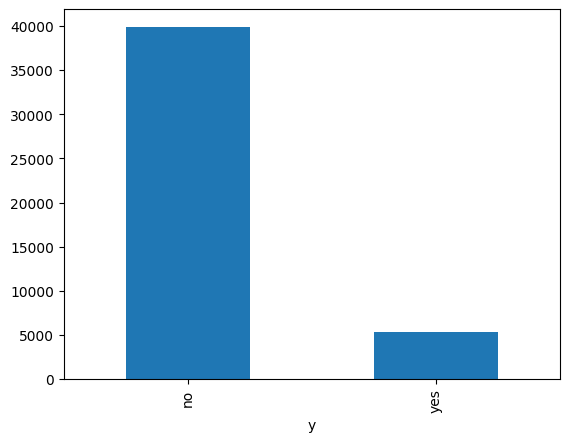

In [18]:
df['y'].value_counts().plot(kind='bar')

VERIFICAMOS QUE HAY UN DESBALANCE SIGNIFICATIVO DE LOS "NO" LO CUAL NOS HARA TOMAR ATENCION A LAS METRICIAS SELECCIONADAS A LA HORA DE REALIZAR EL MODELO PREDICTIVO. 

UNA VEZ QUE TENEMOS LA INFORMACIÓN GENERAL DEL DATASET AVANZAMOS EN NUESTRO ANALISIS. LO PRIMERO QUE HAREMOS ES VER LA RELACION ENTRE CLIENTES QUE DAN EL "SI" PARA ABRIR UN DEPOSITO Y LAS COLUMNAS NUMERICAS.

In [19]:
df.groupby("y")[numerical_columns].mean()

,age,balance,campaign,pdays,previous
y,,,,,
no,40.838986,1303.714969,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,2.141047,68.702968,1.170354


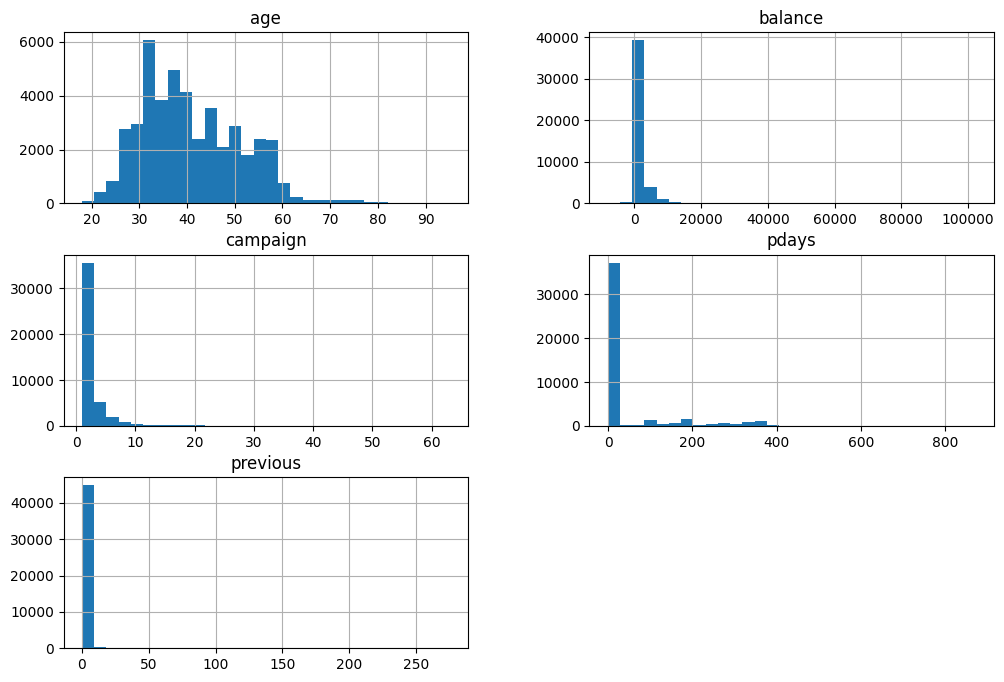

In [20]:
df[numerical_columns].hist(figsize=(12,8), bins=30)
plt.show()

De estos histogramas podemos sacar las siguientes observaciones: 
 - El balance tiene una clara acumulación entre los 1k y 25k pero con outliers que hacen mover a la media hacia un valor mas alto. 
 - La mayoria de los clientes, segun "campaign", tienen entre 3 y 5 llamadas. 
 - Hay una cola extendida en el grafico pdays lo que sugiere que se los llama dentro de un año calendario a cada cliente. 
 - Por lo menos se llamo una vez al cliente antes de esta campaña de marketing. 

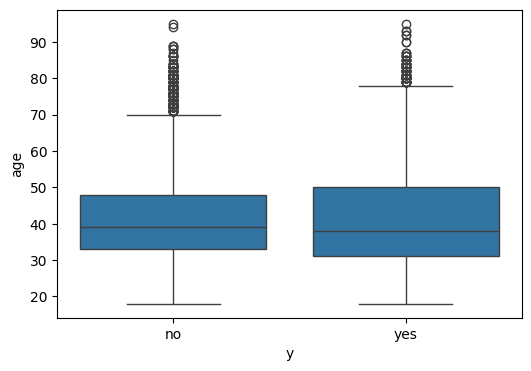

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x='y', y='age', data=df)
plt.show()

LA MEDIA DE EDAD DE LOS CLIENTES SI Y NO ES PRACTICAMENTE IGUAL PERO EL "NO" TIENE MUCHOS MAS OUTLIERS. 

PARA FINALIZAR CON EL EDA Y SEGUIR AVANZANDO EN EL MODELO PROCEDEREMOS A CAMBIAR EL FORMATO DE LA COLUMNA "y".

In [22]:
df['y'] = df['y'].map({'no':0, 'yes':1})
df["y"]

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

HAREMOS UNA PRUEBA DE KNN CON LOS VALORES NUMERICOS TAL COMO LOS TENEMOS PARA VER SU RESULTADO Y A PARTIR DE ALLI EMPEZAR A TRABAJAR EL MODELO.

SEPARAMOS LAS COLUMNAS FEATURES DE TARGET ("y")

In [23]:
features = df.select_dtypes(include=['int64', 'float64'])
target = df["y"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0, stratify=target)

In [25]:
X_train.head()

,age,balance,campaign,pdays,previous,y
32213,35,1350,1,330,1,0
36907,59,145,2,287,13,1
1447,53,1786,2,-1,0,0
10973,37,1170,3,-1,0,0
26982,46,829,7,-1,0,0


In [26]:
y_train.head()

32213    0
36907    1
1447     0
10973    0
26982    0
Name: y, dtype: int64

In [27]:
knn = KNeighborsClassifier(n_neighbors=5)

In [28]:
knn

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [29]:
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [30]:
pred = knn.predict(X_test)
pred

array([0, 0, 0, ..., 1, 0, 0], shape=(9043,))

In [31]:
y_test.values

array([0, 0, 0, ..., 1, 0, 1], shape=(9043,))

In [32]:
knn.score(X_test, y_test) 

0.8781377861329205

LA ACCURACY ES DE 0,88 LO CUAL NOS DICE QUE EL MODELO (SOLO CONTEMPLANDO LAS VARIABLES NUMERICAS) TIENE UN GRAN PORCENTAJE DE EFECTIVIDAD. TENIENDO EN CUENTA QUE EL 88% DE LA COLUMNA "y" ES NO, SEGURAMENTE REPLIQUE ELLO Y HACE QUE EL MODELO DE ESTE PORCENTAJE DE ACCURACY. PROBEMOS CON OTROS TESTS:

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy
print(accuracy_score(y_test, pred))

# precision
print(precision_score(y_test, pred, average='macro'))

# recall
print(recall_score(y_test, pred, average='macro'))

# F1-score
print(f1_score(y_test, pred, average='macro'))

0.8781377861329205
0.6601479278661024
0.5497212992697792
0.5613174739345071


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[7813  172]
 [ 930  128]]
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7985
           1       0.43      0.12      0.19      1058

    accuracy                           0.88      9043
   macro avg       0.66      0.55      0.56      9043
weighted avg       0.84      0.88      0.85      9043



AQUI PODEMOS OBSERVAR COMO A PARTIR DE LOS TEST DE PRECISION, RECALL Y F1 TIENEN UN RESULTADO BASTANTE MAS BAJO LO QUE NOS SUGIERE QUE HABRA QUE ANALIZAR TODAS LAS VARIABLES DEL DF PARA QUE LE MODELO SEA EFICIENTE EN SU TOTALIDAD. 


AVAZAREMOS EN LA MEJORA DEL MODELO REALIZANDO UN BALANCEO, PARA ELLO LO PRIMERO QUE HACEMOS ES PASAR TODAS LAS COLUMNAS CATEGORICAS A NUMERICAS.

In [35]:
columns_to_encode = df.select_dtypes(include="object").columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype = int)
print(df_encoded.columns)

Index(['age', 'balance', 'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [36]:
features_encode = df_encoded.drop('y', axis=1)
target_encode = df_encoded["y"]

In [37]:
features_encode.head()

,age,balance,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,44,29,1,-1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,1,-1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,1,-1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,1,-1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [38]:
target_encode.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features_encode, target_encode, test_size=0.20, random_state=0, stratify=target_encode)

In [40]:
print('y' in features_encode.columns)

False


In [41]:
normalizer = MinMaxScaler()

In [42]:
normalizer.fit(X_train)

,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


In [43]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [44]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_norm, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [45]:
pred = knn.predict(X_test_norm)
pred

array([0, 0, 0, ..., 0, 0, 1], shape=(9043,))

In [46]:
y_test.values

array([0, 0, 0, ..., 1, 0, 1], shape=(9043,))

In [47]:
knn.score(X_test_norm, y_test) 

0.8874267389140772

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy
print(accuracy_score(y_test, pred))

# precision
print(precision_score(y_test, pred, average='macro'))

# recall
print(recall_score(y_test, pred, average='macro'))

# F1-score
print(f1_score(y_test, pred, average='macro'))

0.8874267389140772
0.7252424389557945
0.6004880961822321
0.6290782250759913


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[7786  199]
 [ 819  239]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.55      0.23      0.32      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.60      0.63      9043
weighted avg       0.86      0.89      0.87      9043



HABIENDO HECHO EL ESCALADO DE LA MODELO PODEMOS OBSERVAR QUE LOS RESULTADOS SON MEJORES PERO EL RECALL SIGUE SIENDO UN VALOR BAJO, PROBAREMOS MODIFICANDO EL VALOR DE K PARA BUSCAR LA OPTIMIZACIÓN. 

In [50]:
from sklearn.metrics import recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    pred = knn.predict(X_test_norm)

    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    print(f"k={k:2d} | recall(1)={rec:.3f} | f1(1)={f1:.3f}")

k= 1 | recall(1)=0.286 | f1(1)=0.294
k= 2 | recall(1)=0.134 | f1(1)=0.213
k= 3 | recall(1)=0.251 | f1(1)=0.328
k= 4 | recall(1)=0.171 | f1(1)=0.265
k= 5 | recall(1)=0.226 | f1(1)=0.320
k= 6 | recall(1)=0.164 | f1(1)=0.259
k= 7 | recall(1)=0.215 | f1(1)=0.312
k= 8 | recall(1)=0.175 | f1(1)=0.273
k= 9 | recall(1)=0.212 | f1(1)=0.311
k=10 | recall(1)=0.170 | f1(1)=0.266
k=11 | recall(1)=0.196 | f1(1)=0.294
k=12 | recall(1)=0.169 | f1(1)=0.268
k=13 | recall(1)=0.196 | f1(1)=0.298
k=14 | recall(1)=0.163 | f1(1)=0.260
k=15 | recall(1)=0.183 | f1(1)=0.284
k=16 | recall(1)=0.167 | f1(1)=0.266
k=17 | recall(1)=0.182 | f1(1)=0.283
k=18 | recall(1)=0.167 | f1(1)=0.267
k=19 | recall(1)=0.183 | f1(1)=0.287
k=20 | recall(1)=0.169 | f1(1)=0.270


TENIENDO EN CUENTA LOS RESULTADOS NOS QUEDAREMOS CON K = 3 YA QUE ES EL QUE MEJOR RESULTADO ARROJA.

AVANCEMOS EN EL TESTEO DE OTROS MODELOS PARA OBTENER OTROS RESULTADOS Y DECIDIR CON CUAL NOS COVENDRA QUEDARNOS:

- LOGISTIC REGRESSION
- DECISION TREE
- RANDOM FOREST
- BAGGING
- ADABOOST
- GRADIENT BOOSTING

**LOGISTIC REGRESSION**

In [51]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_norm, y_train)

pred_log = log_reg.predict(X_test_norm)

print(classification_report(y_test, pred_log))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.64      0.18      0.28      1058

    accuracy                           0.89      9043
   macro avg       0.77      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043



COMPARANDOLO CON EL KNN (K=3) TENEMOS UNA MEJORA UNICAMENTE EN LA PRECISION. COMPAREMOS LOS RESULTADOS HACIENDO class_weight = "balanced" PARA QUE LE DE "MAS" IMPORTANCIA A LOS "yes".

In [52]:
log_reg_bal = LogisticRegression(max_iter=1000, class_weight='balanced')

log_reg_bal.fit(X_train_norm, y_train)

pred_bal = log_reg_bal.predict(X_test_norm)

print(confusion_matrix(y_test, pred_bal))
print(classification_report(y_test, pred_bal))

[[6214 1771]
 [ 392  666]]
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      7985
           1       0.27      0.63      0.38      1058

    accuracy                           0.76      9043
   macro avg       0.61      0.70      0.62      9043
weighted avg       0.86      0.76      0.80      9043



PODEMOS OBSERVAR QUE LA ACCURACY Y LA PRECISION DISMINUYEN PERO LA VARIABLE RECALL SUBE NOTORIAMENTE.

**DECISION TREE**

In [53]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

tree_limited = DecisionTreeClassifier(
    max_depth=5,
    random_state=0
)

tree_limited.fit(X_train_norm, y_train)

pred_tree_limited = tree_limited.predict(X_test_norm)

print(classification_report(y_test, pred_tree_limited))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.73      0.14      0.23      1058

    accuracy                           0.89      9043
   macro avg       0.82      0.56      0.59      9043
weighted avg       0.88      0.89      0.86      9043



AQUI VEMOS UNA MEJORA EN LA PRECISION PERO UN RECALL MUY BAJO, COMPAREMOS LOS RESULTADOS HACIENDO class_weight = "balanced" PARA QUE LE DE "MAS" IMPORTANCIA A LOS "yes".

In [55]:
tree_bal = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=0
)

tree_bal.fit(X_train_norm, y_train)

pred_tree_bal = tree_bal.predict(X_test_norm)

print(classification_report(y_test, pred_tree_bal))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7985
           1       0.31      0.56      0.40      1058

    accuracy                           0.80      9043
   macro avg       0.62      0.70      0.64      9043
weighted avg       0.86      0.80      0.83      9043



AL IGUAL QUE EN LR, EL RECALL Y F1 AUMENTAN EN LOS YES Y LA PRECISION DISMINUYE. 

**RANDOM FOREST**

In [56]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)

forest.fit(X_train_norm, y_train)
pred_rf = forest.predict(X_test_norm)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.67      0.24      0.35      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.61      0.65      9043
weighted avg       0.88      0.90      0.87      9043



EN ESTE CASO EL RESULTADO ES SIMILAR A KNN POR LO QUE UTLIZAREMOS class_weight = "balanced" PARA QUE LE DE "MAS" IMPORTANCIA A LOS "yes".

In [57]:
forest_bal = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=0
)

forest_bal.fit(X_train_norm, y_train)

pred_rf_bal = forest_bal.predict(X_test_norm)

print(classification_report(y_test, pred_rf_bal))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      7985
           1       0.51      0.37      0.43      1058

    accuracy                           0.88      9043
   macro avg       0.72      0.66      0.68      9043
weighted avg       0.87      0.88      0.88      9043



DE ACUERDO A LOS RESULTADOS, PODEMOS DECIR QUE EN EL MARCO GENERAL TIENE LOS MEJORES RESULTADOS YA QUE MEJORA LA DETECCION DE CLIENTES POTENCIALES Y A SU VEZ NO TENDRIA GRANDES NUMEROS DE FALSOS POSITIVOS. 

**BAGGING**

In [58]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging = BaggingClassifier(estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=0
)

bagging.fit(X_train_norm, y_train)
pred_bag = bagging.predict(X_test_norm)

print(confusion_matrix(y_test, pred_bag))
print(classification_report(y_test, pred_bag))

[[7787  198]
 [ 776  282]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.59      0.27      0.37      1058

    accuracy                           0.89      9043
   macro avg       0.75      0.62      0.65      9043
weighted avg       0.87      0.89      0.87      9043



**ADAPTIVE BOOST**

In [59]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=100)
ada.fit(X_train_norm, y_train)

pred_ada = ada.predict(X_test_norm)

print(confusion_matrix(y_test, pred_ada))
print(classification_report(y_test, pred_ada))

[[7794  191]
 [ 852  206]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.52      0.19      0.28      1058

    accuracy                           0.88      9043
   macro avg       0.71      0.59      0.61      9043
weighted avg       0.86      0.88      0.86      9043



**GRADIENT BOOSTING**

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gb_reg = GradientBoostingClassifier(max_depth=20,
                                   n_estimators=100)

gb_reg.fit(X_train_norm, y_train)
pred_gb = gb_reg.predict(X_test_norm)

print(confusion_matrix(y_test, pred_gb))
print(classification_report(y_test, pred_gb))

[[7791  194]
 [ 832  226]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.54      0.21      0.31      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.59      0.62      9043
weighted avg       0.86      0.89      0.86      9043



**DE MOMENTO NOS QUEDAMOS CON RANDONFOREST SIN BALANCEAR**

### PROBAREMOS RANDOM FOREST SIN HACER DUMMIES PARA LUEGO AVANZAR PROBANDOLO CON HYPERTUNING Y LUEGO BALANCEANDOLO

In [61]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,may,1,-1,0,unknown,0


In [62]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


features = df.drop(columns = ["y"])
target = df["y"]

In [63]:
features.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,may,1,-1,0,unknown


In [64]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0, stratify=target)

In [65]:
cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

UTILIZAMOS LA LIBRERIA ONEHOTENCODER PARA PASARLAS A NUMERICAS EVITANDO HACER DUMMIES. 

In [66]:
preprocess = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols), ("num", "passthrough", num_cols),])

MODELAMOS EL RF

In [67]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=0,
    class_weight="balanced",
    n_jobs=-1
)

UTILIZAMOS PIPELINE PARA QUE COMBINE TODOS LOS PASOS. 

In [68]:
rf_pipe = Pipeline(steps=[ ("prep", preprocess), ("model", rf) ])

ENTRENAMOS AL MODELO PARA OBTENER LOS RESULTADOS Y COMPARARLOS. 

In [69]:
rf_pipe.fit(X_train, y_train)
pred = rf_pipe.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred))

Confusion matrix:
 [[7853  132]
 [ 833  225]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.63      0.21      0.32      1058

    accuracy                           0.89      9043
   macro avg       0.77      0.60      0.63      9043
weighted avg       0.87      0.89      0.87      9043



COMPARANDO LOS RESULTADOS DEL MODELO RF(CON DUMMIES) CON ESTE RF(PIPELINE), OBTENEMOS MEJORES RESULTADOS EN EL PRIMERO POR LO QUE PROCEDEREMOS A TRABAJAR CON HYPERTUNNING E IMBALANCED CON ESTE RF.

In [70]:
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)

forest.fit(X_train_norm, y_train)
pred_rf = forest.predict(X_test_norm)
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.63      0.23      0.34      1058

    accuracy                           0.89      9043
   macro avg       0.77      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043



PREVIO A HACER LOS TESTEOS HAREMOS UNA PRUEBA DEL RF AGREGANDOLE UN CLASSWEIGHT PARA COMPARAR RESULTADOS. 

In [71]:
forest_bal = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)

forest_bal.fit(X_train_norm, y_train)
pred_bal = forest_bal.predict(X_test_norm)

print(classification_report(y_test, pred_bal))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      7985
           1       0.48      0.35      0.41      1058

    accuracy                           0.88      9043
   macro avg       0.70      0.65      0.67      9043
weighted avg       0.87      0.88      0.87      9043



PODEMOS OBSERVAR UNA SUBA CONSIDERABLE DE RECALL POR LO QUE NOS QUEDAREMOS CON FOREST_BAL PARA TRABAJAR CON GRID

In [72]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42
)

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_norm, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\HP\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1: 0.4447322550785241


In [73]:
best_rf = grid.best_estimator_
pred_best = best_rf.predict(X_test_norm)

print(confusion_matrix(y_test, pred_best))
print(classification_report(y_test, pred_best))


[[7364  621]
 [ 549  509]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      7985
           1       0.45      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.70      0.70      9043
weighted avg       0.87      0.87      0.87      9043



LOS RESULTADOS DEL GRID SON MUY BUENOS, HAN MEJORADO CASI TODAS LAS METRICAS LOGRANDO QUE EL MODELO SEA MAS ROBUSTO. VAMOS A HACER LA ULTIMA PRUEBA CON SMOTE PARA COMPARAR QUE NOS DA MEJOR Y EN BASE A ELLO DEFINIREMOS EL MODELO FINAL.

In [74]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train_norm, y_train)

VERIFICAMOS QUE QUEDE BALANCEADO

In [75]:
print(y_train.value_counts())
print(y_train_sm.value_counts())

y
0    31937
1     4231
Name: count, dtype: int64
y
0    31937
1    31937
Name: count, dtype: int64


PROCEDEMOS A ENTRENARLO PARA VERIFICAR SUS RESULTADOS.

In [76]:
rf_smote = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

rf_smote.fit(X_train_sm, y_train_sm)

pred_smote = rf_smote.predict(X_test_norm)

print(confusion_matrix(y_test, pred_smote))
print(classification_report(y_test, pred_smote))

[[7374  611]
 [ 590  468]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7985
           1       0.43      0.44      0.44      1058

    accuracy                           0.87      9043
   macro avg       0.68      0.68      0.68      9043
weighted avg       0.87      0.87      0.87      9043



TENIENDO EN CUENTA ESTOS RESULTADOS, NUESTRO MODELO FINAL SERA EL RF(CLASSWEIGHT "BALANCED") CON GRIDSEARCH. PROCEDEREMOS A GUARDARLO UTILIZANDO JOBLIB. CON ESTO, UNA VEZ QUE RECIBAMOS UNA BASE DE CLIENTES PODREMOS PREDECIR QUE CLIENTES HARIAN UN DEPOSITO POR LO QUE NUESTRO EQUIPO DE VENTA PODRA PRIORIZAR LA LLAMADA A AQUELLOS QUE DIERON SI EN EL MODELO.

In [77]:
best_rf = grid.best_estimator_

import joblib

joblib.dump(best_rf, "random_forest_model.pkl")

print("Modelo guardado como random_forest_model.pkl")

Modelo guardado como random_forest_model.pkl
